# **NB03 - Data Visualisation**

**Objective:** This notebook visualises the data found in `processed_database`. An index of economic stability was created in order to clearly interpret the economic situation of a country using the World Bank API data. The raw data and economic stability index was initially explored through bar charts and tables. Then, the final visualisations can be found in the notebook below:
- Bar chart: journalistic tone vs economic stability index
- Bar chart: economic status vs. demand for democracy 
- Bar chart: economic inequality vs. polarisation 
- Geopandas map: average Goldstein score and average economic stability score per country

**Imports:**

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import visuals
import functions
import geopandas as gpd
from shapely import *
import shapefile
import pycountry
from shapely.geometry import shape

Note: temporarily reading gdelt from a csv while we wait for the gdelt data to be uploaded to the database

# 1. Read the data from the database 

1.1 Reestablish a connection to the database

In [22]:
engine = create_engine('sqlite:///../data/processed/processed_database.db', echo=False, isolation_level="AUTOCOMMIT")

1.2 Read `vdem_data`, `world_bank`, and `gdelt_data` from the database

In [23]:
vdem_data = pd.read_sql('vdem_data', engine)

In [24]:
world_bank = pd.read_sql('world_bank', engine)

In [25]:
gdelt_data = pd.read_sql('gdelt_events', engine)

# 2. Create an economic stability index

2.1 Store the score of each country and year in a dataframe

In [26]:
country_ids = ['US', 'BR', 'IN', 'FR', 'IR', 'ZA']
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

results = []
for country in country_ids:
    for year in years:
        total_score = functions.economic_stability_score(country, year)  # Function returns a score between 0-27
        results.append({'country_id': country, 'year': year, 'total_economic_score': total_score})

economic_stability_index_df = pd.DataFrame(results)
economic_stability_index_df = functions.calculate_economic_index(economic_stability_index_df)

# 3. Initial data exploration

### 3.1 Economic Stability Index in Each Country over Time:

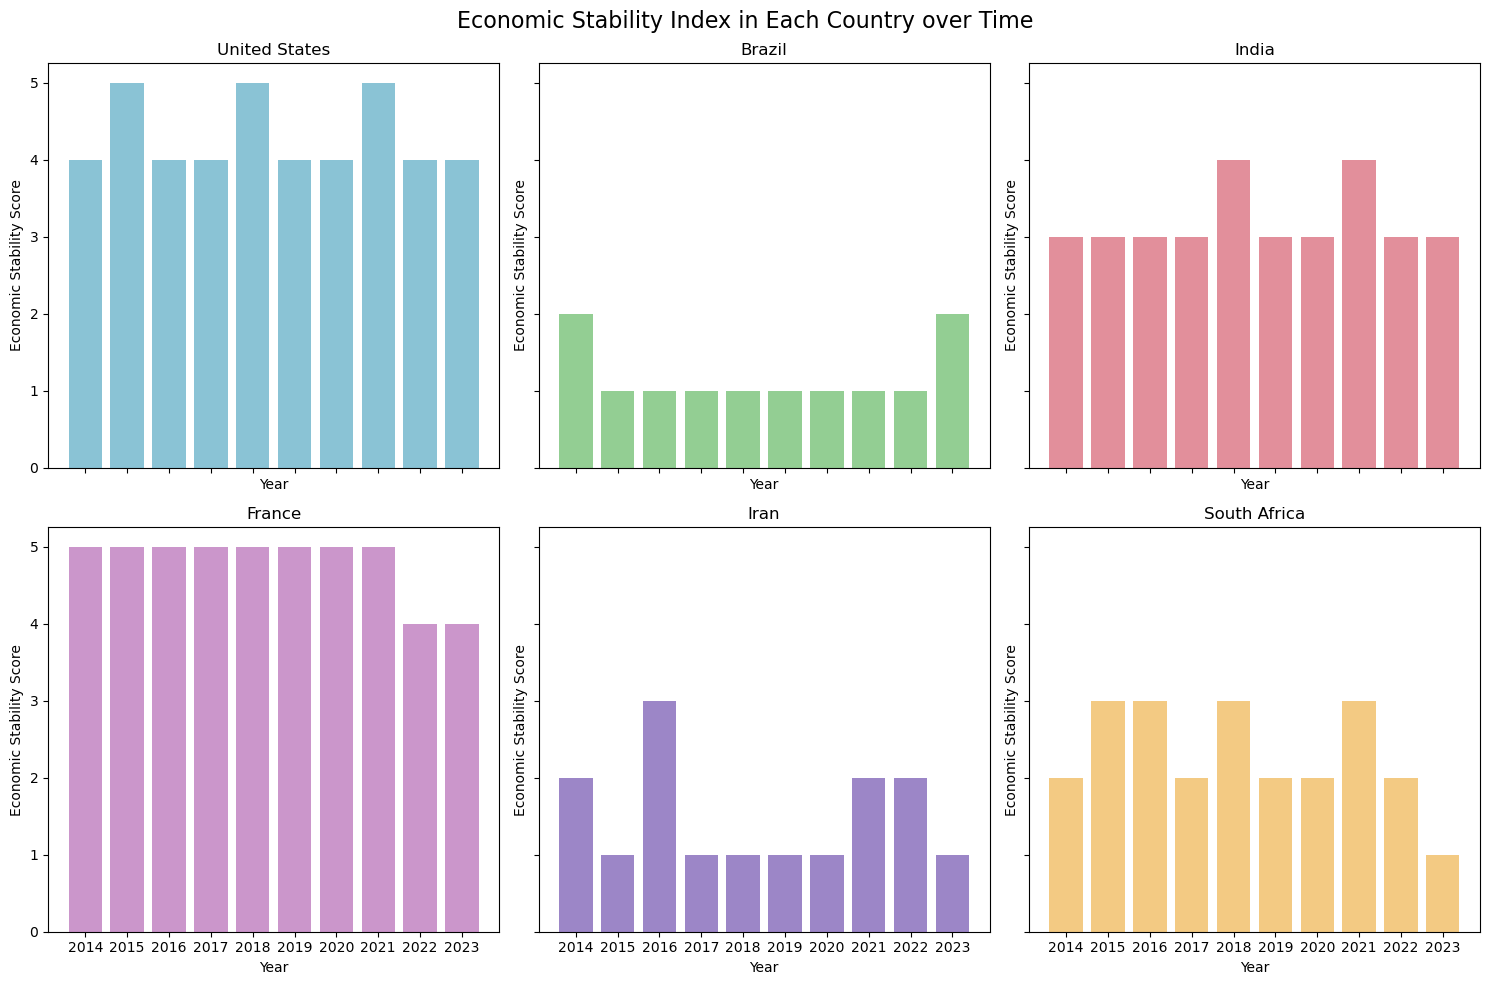

In [27]:
countries = economic_stability_index_df["country_id"].unique()
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

grouped = economic_stability_index_df.groupby(["country_id", "year"])["economic_index"].mean().reset_index()

for i, country in enumerate(countries):
    country_data = grouped[grouped["country_id"] == country]
    ax = axes[i]
    ax.bar(country_data["year"], country_data["economic_index"], color=visuals.country_colors[country])
    ax.set_title(visuals.country_labels[country])
    ax.set_xlabel("Year")
    ax.set_ylabel("Economic Stability Score")
    ax.set_xticks(country_data["year"])

plt.suptitle('Economic Stability Index in Each Country over Time', fontsize=16)

plt.tight_layout()
plt.show()

### 3.2 Tone of Political Journalism in Each Country over Time:
This uses the average tone of all GDELT events for each country per year.

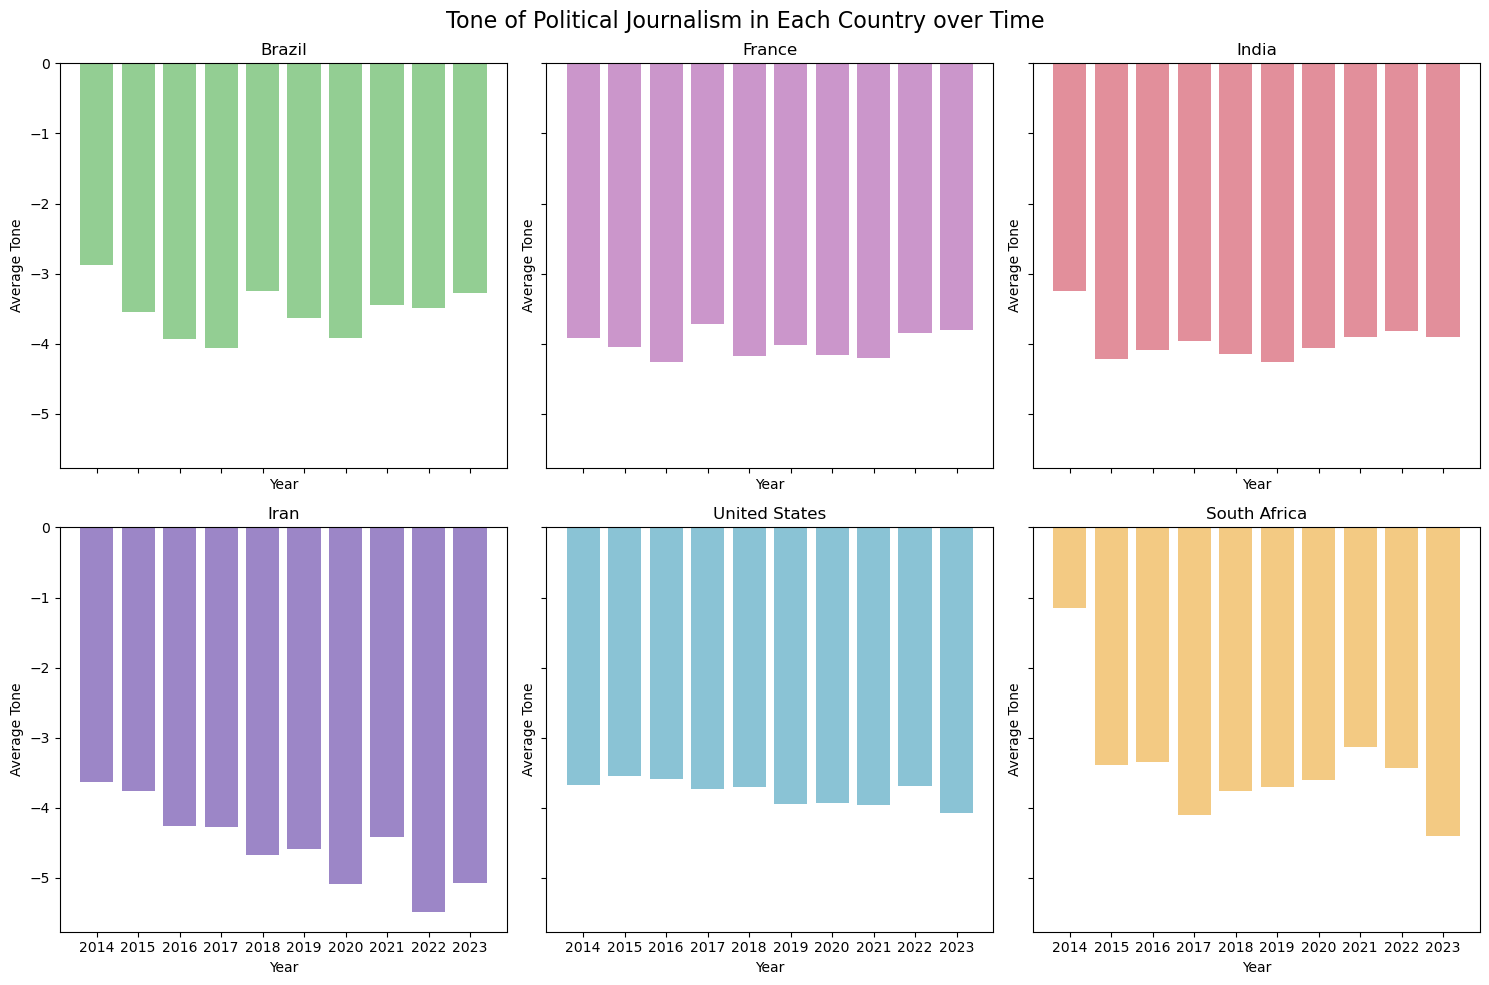

In [28]:
countries = gdelt_data["country_code"].unique()
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

grouped = gdelt_data.groupby(["country_code", "year"])["avg_tone"].mean().reset_index()

for i, country in enumerate(countries):
    country_data = grouped[grouped["country_code"] == country]
    ax = axes[i]
    ax.bar(country_data["year"], country_data["avg_tone"], color=visuals.country_colors[country])
    ax.set_title(visuals.country_labels[country])
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Tone")
    ax.set_xticks(country_data["year"])

plt.suptitle('Tone of Political Journalism in Each Country over Time', fontsize=16)

plt.tight_layout()
plt.show()

### 3.3 Table of Average Tone per Event Category (all years)

In [29]:
gdelt_data['event_category'] = gdelt_data['EventCode'].apply(functions.categorize_event)

avg_tone_occurrences_by_category = (
    gdelt_data.groupby('event_category')[['avg_tone', 'num_occurrences']]
    .mean()
    .reset_index()
    .sort_values(by='num_occurrences', ascending=False)
)
print("Average tone and number of occurrences by event type category:")
avg_tone_occurrences_by_category

Average tone and number of occurrences by event type category:


,event_category,avg_tone,num_occurrences
1,11,-4.368958,22674.671576
5,18,-5.366635,5700.120357
3,14,-4.358484,4409.988506
2,13,-3.443301,3993.560533
0,10,-3.123974,3213.703786
4,15,-2.844606,1986.863158
6,20,-3.870891,365.814103


### 3.4 and 3.5 Tone and Rates of Events per Country (all years)

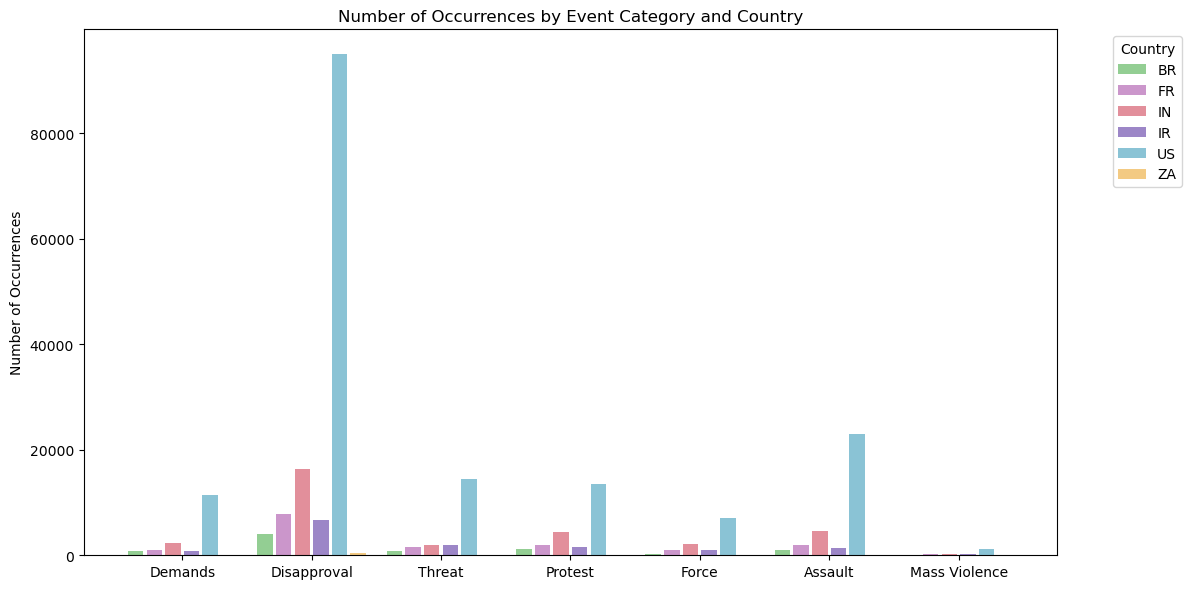

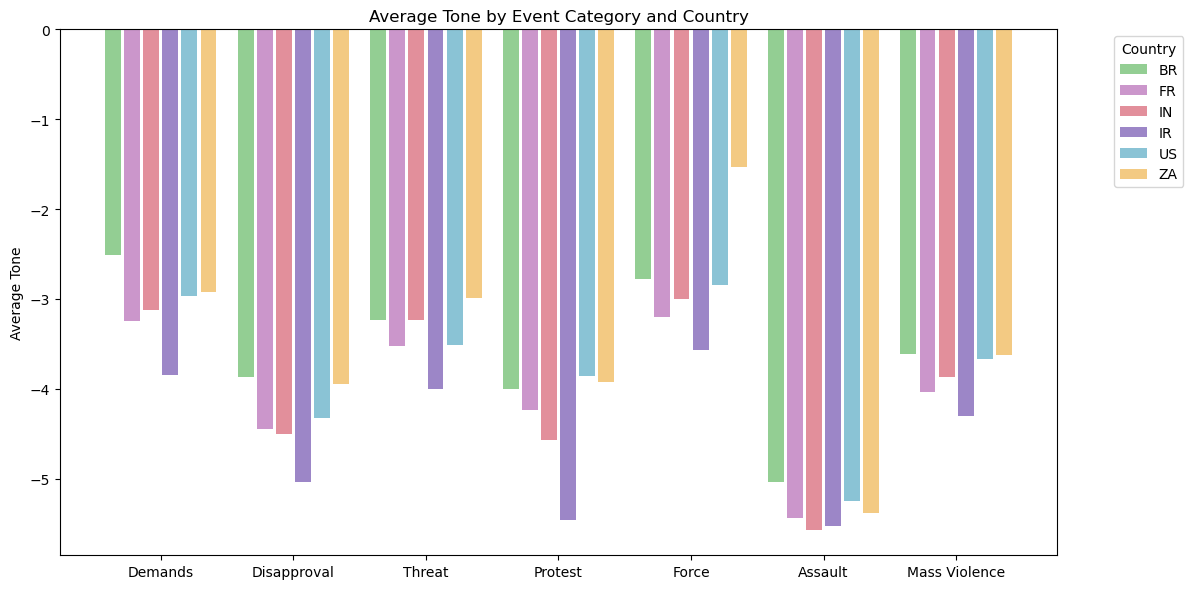

In [30]:
grouped_data = gdelt_data.groupby(['event_category', 'country_code'])[['num_occurrences', 'avg_tone']].mean().reset_index()
event_categories = grouped_data['event_category'].unique()
countries = grouped_data['country_code'].unique()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(event_categories))
bar_width = 0.12
offsets = np.linspace(-bar_width * len(countries) / 2, bar_width * len(countries) / 2, len(countries))

for i, country in enumerate(countries):
    country_data = grouped_data[grouped_data['country_code'] == country]
    occurrences = country_data.set_index('event_category').reindex(event_categories)['num_occurrences']
    ax.bar(x + offsets[i], occurrences, bar_width, label=country, color=visuals.country_colors[country])
ax.set_xticks(x)
ax.set_xticklabels(event_categories)
ax.set_xticklabels([visuals.category_labels[category] for category in event_categories])
ax.set_ylabel('Number of Occurrences')
ax.set_title('Number of Occurrences by Event Category and Country')
ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
for i, country in enumerate(countries):
    country_data = grouped_data[grouped_data['country_code'] == country]
    avg_tones = country_data.set_index('event_category').reindex(event_categories)['avg_tone']
    ax.bar(x + offsets[i], avg_tones, bar_width, label=country, color=visuals.country_colors[country])

ax.set_xticks(x)
ax.set_xticklabels(event_categories)
ax.set_xticklabels([visuals.category_labels[category] for category in event_categories])
ax.set_ylabel('Average Tone')
ax.set_title('Average Tone by Event Category and Country')
ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3.6 Attempted Rescaling of Event Rates by Population 
The US is very overrepresented in the num_occurence column (see graph above). One idea we had was to rescale the num_occurences by the population size of each country; however for India and Brazil (also very large populations), we worried this might under-represent their number of occurences. 

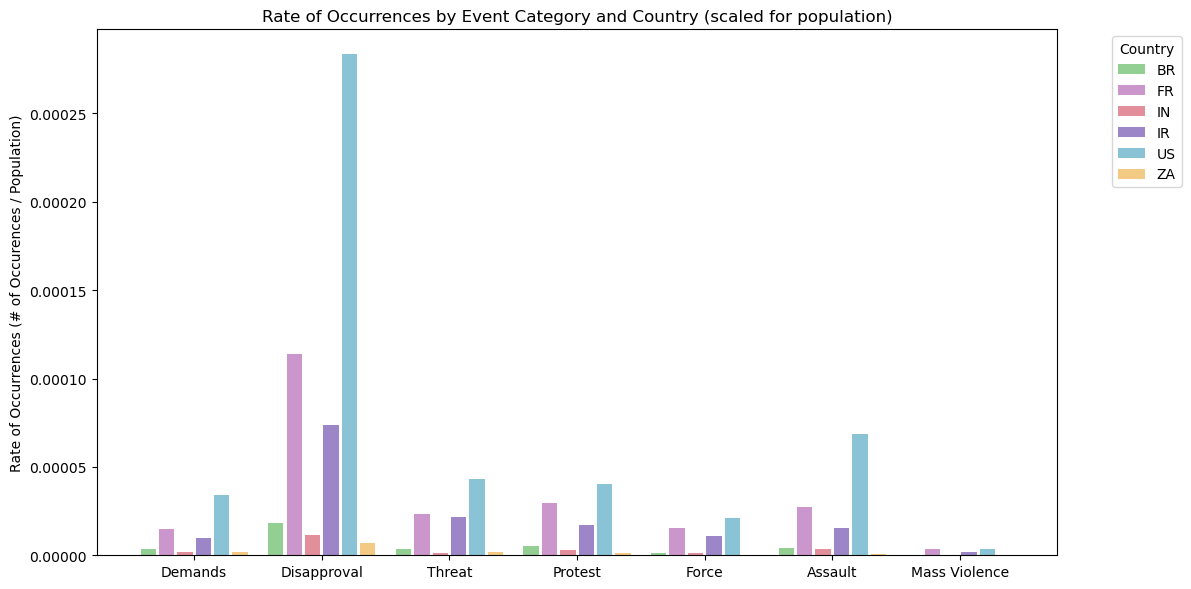

In [31]:
grouped_data = gdelt_data.groupby(['event_category', 'country_code'])[['num_occurrences', 'avg_tone']].mean().reset_index()
event_categories = grouped_data['event_category'].unique()
countries = grouped_data['country_code'].unique()


fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(event_categories))
bar_width = 0.12 
offsets = np.linspace(-bar_width * len(countries) / 2, bar_width * len(countries) / 2, len(countries))
for i, country in enumerate(countries):
    country_data = grouped_data[grouped_data['country_code'] == country]
    occurrences = (
        country_data.set_index('event_category').reindex(event_categories)['num_occurrences'] 
        / visuals.country_populations[country]
        )
    ax.bar(x + offsets[i], occurrences, bar_width, label=country, color=visuals.country_colors[country])
ax.set_xticks(x)
ax.set_xticklabels(event_categories)
ax.set_xticklabels([visuals.category_labels[category] for category in event_categories])
ax.set_ylabel('Rate of Occurrences (# of Occurences / Population)')
ax.set_title('Rate of Occurrences by Event Category and Country (scaled for population)')
ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3.7 Actions Relating to Democratization per Country per Year
Created an index that represented actions moving a country in the direction of democracy vs. anti democratic actions / actions moving a country towards authoritarianism.

**Score of 1 (democratization)**
- demand leadership change
- demand policy change
- demand rights
- demand change in institutions or regime 
- threaten political dissent (by civilians)
- social movement, protest, or strike (general)
- social movement, protest, or strike for leadership change
- social movement, protest, or strike for policy change
- social movement, protest, or strike for change in institutions 
- social movement, protest, or strike for human rights 
- demand humanitarian aid
- demand political reform
- accuse of humans rights abuses 
- rally opposition against
- threaten a boycott or strike
    
**Score of -1 (anti democratic)**
- demand easing of political dissent
- threaten w/ restrictions on politcal freedoms
- threaten to ban political parties or politicians
- threaten curfew
- threaten martial law
- threaten w/ repression
- threaten occupation 
- threaten unconventional mass violence
- increase and/or mobilize military and/or police power (upon civilians)
- torture 
- mass expulsion
- mass killings
- ethnic cleansing

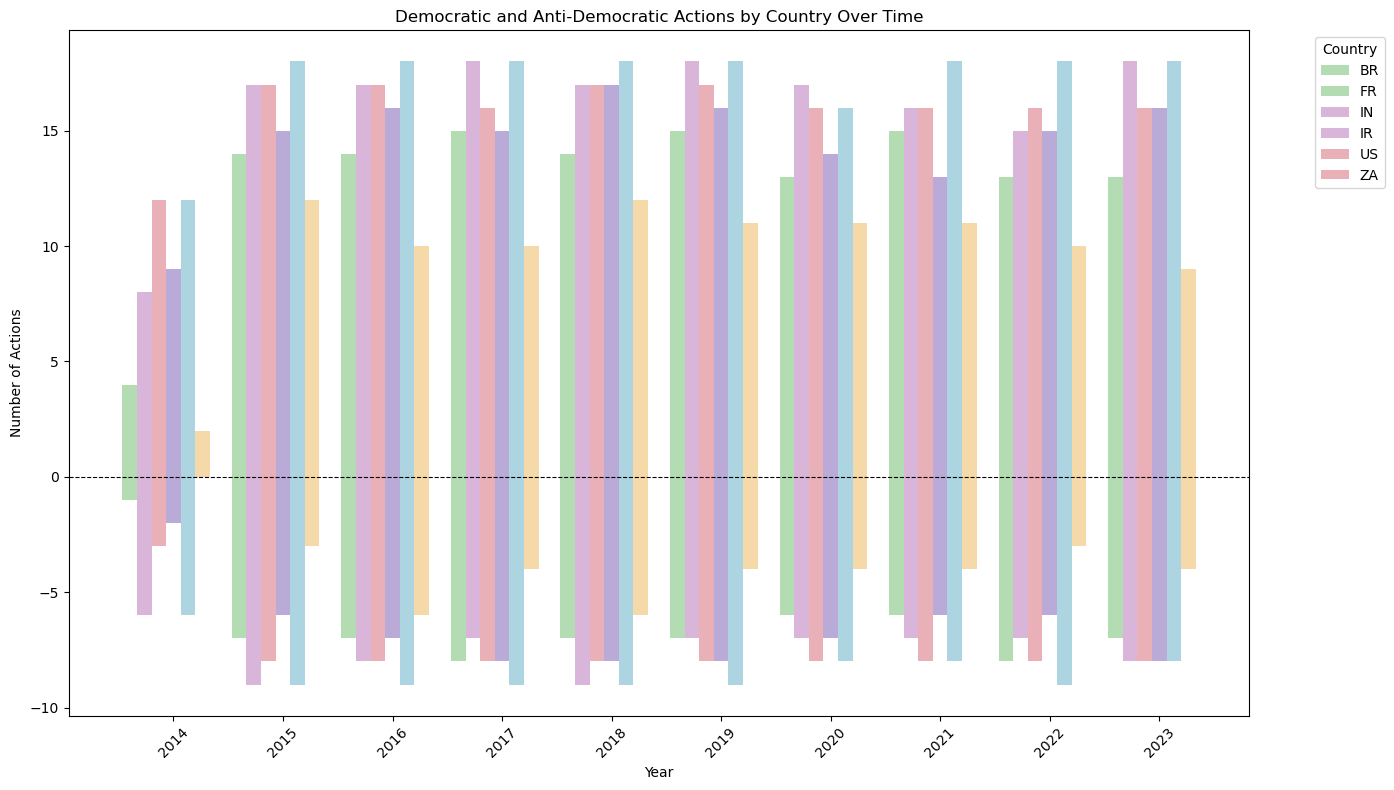

In [32]:
gdelt_data['democratic_actions'] = gdelt_data['EventCode'].apply(functions.act_on_democracy)

grouped_data = gdelt_data.groupby(['year', 'country_code']).agg(
    democratic_count=('democratic_actions', lambda x: (x == 1).sum()),  
    anti_democratic_count=('democratic_actions', lambda x: (x == -1).sum())  
).reset_index()

years = grouped_data['year'].unique()
countries = grouped_data['country_code'].unique()


fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(years))
bar_width = 0.8  
offset = bar_width / 2  

for i, country in enumerate(countries):
    country_data = grouped_data[grouped_data['country_code'] == country]
    democratic_count = country_data.set_index('year').reindex(years)['democratic_count'].fillna(0)
    anti_democratic_count = country_data.set_index('year').reindex(years)['anti_democratic_count'].fillna(0)
    
    ax.bar(
        x + i * (bar_width / len(countries)) - offset,
        democratic_count,
        bar_width / len(countries),
        label=f'{country} - Democratic',
        alpha=0.7,
        color=visuals.country_colors[country]
    )
    
    ax.bar(
        x + i * (bar_width / len(countries)) - offset,
        -anti_democratic_count,  
        bar_width / len(countries),
        label=f'{country} - Anti-Democratic',
        alpha=0.7,
        color=visuals.country_colors[country]
    )

ax.set_xticks(x)
ax.set_xticklabels(years, rotation=45)
ax.set_ylabel('Number of Actions')
ax.set_xlabel('Year')
ax.set_title('Democratic and Anti-Democratic Actions by Country Over Time')

ax.legend(title='Country', labels=countries, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add horizontal line at 0 for separation
plt.tight_layout()
plt.show()


** from the above visualization, it appears that the US is not over-repressented on the actions we are most concerned with. its previous over-respresentation in visualization 4 and 6 is no longer shown when we narrow our focus to events directly pertaining to democracy, social movements, authoritarianism, etc. 

# 4. Final Visualisations

### 4.1 Journalistic Tone vs Economic Index

This bar chart represents the average tone of journalistic events compared to the economic state. Countries and years will be aggregated by economic condition and a weighted average of journalistic tone will be used as the dependent variable. 

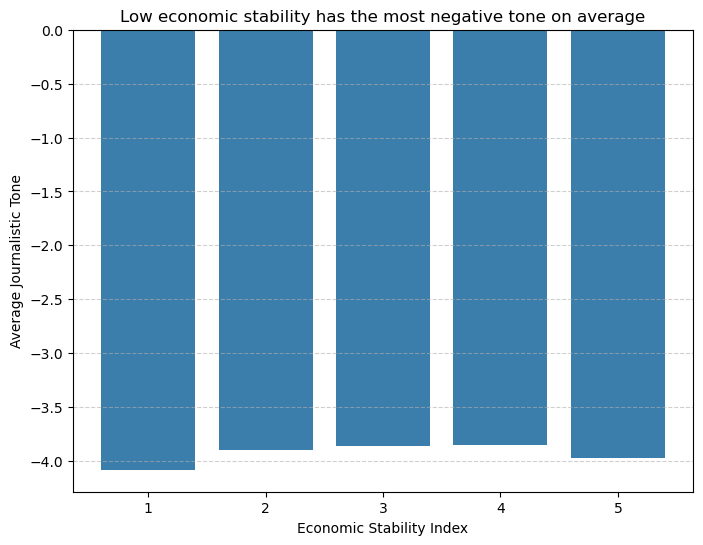

In [33]:
merged_df = gdelt_data.merge(
    economic_stability_index_df, 
    left_on=["country_code", "year"], 
    right_on=["country_id", "year"], 
    how="inner")

merged_df.drop(columns=["country_id"], inplace=True)

avg_tone_by_economic_index = merged_df.groupby('economic_index')['avg_tone'].mean()

plt.figure(figsize=(8, 6))
plt.bar(avg_tone_by_economic_index.index, avg_tone_by_economic_index.values, color='#3b7dab')
plt.xlabel("Economic Stability Index")
plt.ylabel("Average Journalistic Tone")
plt.title("Low economic stability has the most negative tone on average")
plt.xticks(range(1, 6)) 
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

### 4.2 Economic Status vs Demands for Democracy 

This bar chart represents the economic condition of a country compared to actions directly influencing democracy, using the democratization scores and the economic stability index we created.

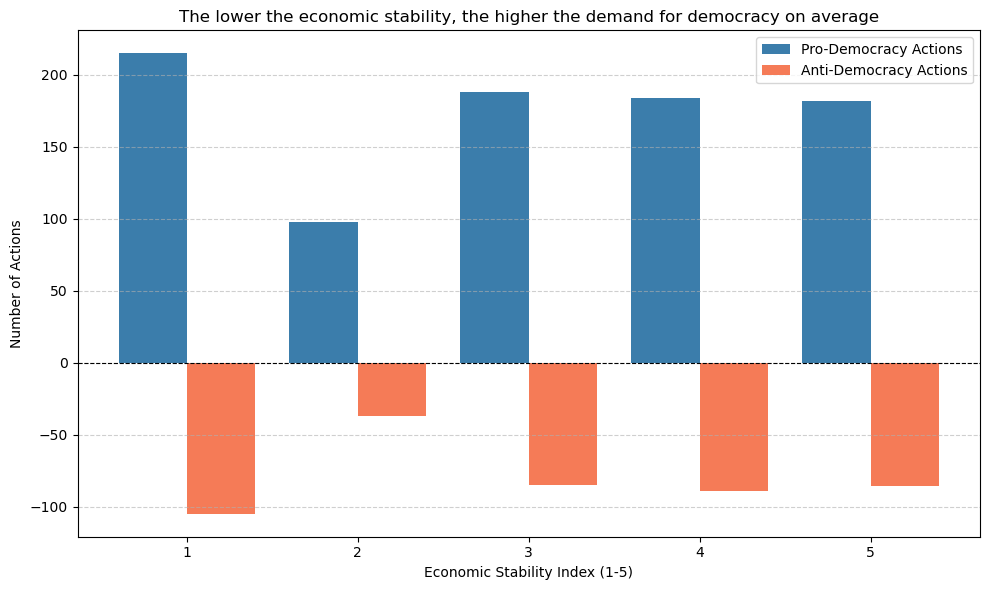

In [34]:
merged_df = gdelt_data.merge(
    economic_stability_index_df, 
    left_on=["country_code", "year"], 
    right_on=["country_id", "year"], 
    how="inner"
)

merged_df.drop(columns=["country_id"], inplace=True)

# Apply democracy classification
merged_df['democratic_actions'] = merged_df['EventCode'].apply(functions.act_on_democracy)

# Ensure economic index is an integer from 1 to 5
merged_df["economic_index"] = merged_df["economic_index"].astype(int)

# Group by economic index and compute democratic/anti-democratic counts
binned_data = merged_df.groupby("economic_index").agg(
    democratic_count=('democratic_actions', lambda x: (x == 1).sum()),  
    anti_democratic_count=('democratic_actions', lambda x: (x == -1).sum())  
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(binned_data))

bar_width = 0.4

democracy_color = "#3b7dab" 
anti_democracy_color = "#f57b57"

# Democratic Actions (positive bars)
ax.bar(x - bar_width/2, binned_data["democratic_count"], bar_width, label="Pro-Democracy Actions", color=democracy_color)

# Anti-Democratic Actions (negative bars)
ax.bar(x + bar_width/2, -binned_data["anti_democratic_count"], bar_width, label="Anti-Democracy Actions", color=anti_democracy_color)
plt.grid(axis="y", linestyle="--", alpha=0.6)

ax.set_xticks(x)
ax.set_xticklabels(binned_data["economic_index"])
ax.set_xlabel("Economic Stability Index (1-5)")
ax.set_ylabel("Number of Actions")
ax.set_title("The lower the economic stability, the higher the demand for democracy on average")
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.legend()

plt.tight_layout()
plt.show()

### 4.3 Economic Inequality (GINI Index) vs. Political Polarisation 

This bar chart depicts the relationship between economic inequality (represented through the GINI Index) from the World Bank and political polarisation from the V-Dem dataset. A GINI Index score of 100 indicates perfect economic inequality, and a score of 0 indicates perfect equality. The polarisation values are explained as followed from the V-dem codebook:
- 0: Not at all. Supporters of opposing political camps generally interact in a friendly manner.
- 1: Mainly not. Supporters of opposing political camps are more likely to interact in a friendly
than a hostile manner.
- 2: Somewhat. Supporters of opposing political camps are equally likely to interact in a friendly
or hostile manner.
- 3: Yes, to noticeable extent. Supporters of opposing political camps are more likely to interact
in a hostile than friendly manner.
- 4: Yes, to a large extent. Supporters of opposing political camps generally interact in a hostile
manner.

4.3.1 Prepare the dataframe for visualisation

In [ ]:
gini_df = world_bank[world_bank['indicator_id'] == 'SI.POV.GINI']
gini_df.rename(columns={"value": "gini_value"}, inplace=True)

In [ ]:
interesting_columns = ['country_text_id', 'year', 'v2cacamps']
polarisation_df = vdem_data[interesting_columns]
polarisation_df.rename(columns={"country_text_id": "country_id"}, inplace=True)

In [37]:
merged_df = gini_df.merge(polarisation_df, on=["country_id", "year"], how="inner").drop(columns=["iso3code", "indicator_id", "country_id", 'indicator_name'])

4.3.1 Plot the data

In [ ]:
bins = np.arange(0, 101, 5)  
merged_df["gini_bin"] = pd.cut(merged_df["gini_value"], bins)

binned_data = merged_df.groupby("gini_bin")["v2cacamps"].mean().reset_index()

binned_data["gini_midpoint"] = binned_data["gini_bin"].apply(lambda x: (x.left + x.right) / 2)

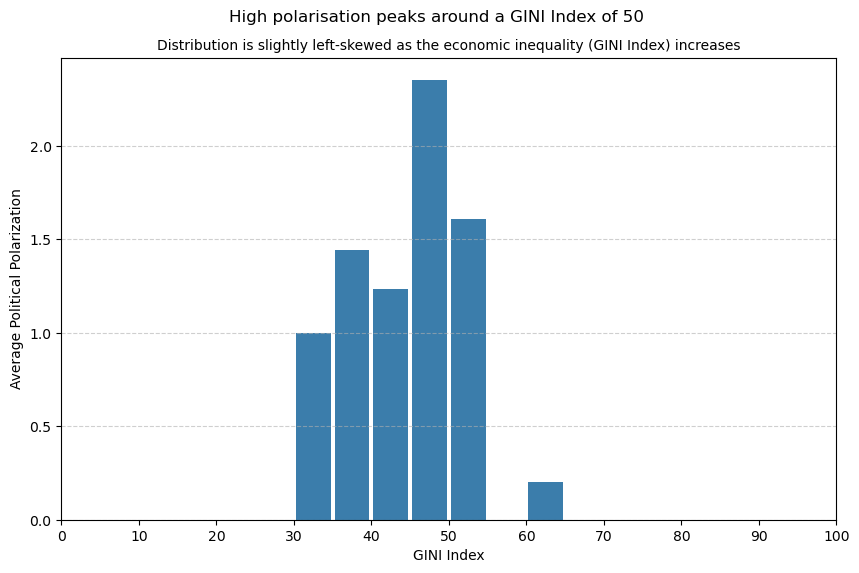

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(binned_data["gini_midpoint"], binned_data["v2cacamps"], width=4.5, color="#3b7dab")

plt.xlabel("GINI Index")
plt.ylabel("Average Political Polarization")
plt.suptitle("High polarisation peaks around a GINI Index of 50", y=0.96)
plt.title("Distribution is slightly left-skewed as the economic inequality (GINI Index) increases", fontsize=10)

plt.xticks(np.arange(0, 110, 10)) # every ten points
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


### 4.4 Average Goldstein Score and Economic Stability Score per Country 

This geopandas world map depicts the relationship between the average Goldstein score from the GDELT data and the average economic stability score from the world bank data. This represents the political stability of a country, thus indicating the public sentiment towards democracy in the context of the country's economic system. 

4.4.1 Extract the average Goldstein score and average the score across ten years for each country

In [40]:
goldstein_df = gdelt_data[['country_code', 'avg_goldstein', 'year']]
goldstein_avg_df = goldstein_df.groupby('country_code')['avg_goldstein'].mean().reset_index()

4.4.2 Extract the average economic stability score and average the score across ten years for each country

In [41]:
economic_score_df = economic_stability_index_df[['country_id', 'total_economic_score', 'year']]
economic_avg_df = economic_score_df.groupby('country_id')['total_economic_score'].mean().reset_index()

4.4.3 Generate the `world` dataframe and change the country code from ALPHA-3 to ALPHA-2 in order to merge with the Goldstein and economic score

NOTE: France's country code needs to be manually changed

In [42]:
world = functions.get_naturalearth_data(columns=["NAME", "ISO_A3", "CONTINENT", "geometry"])

In [43]:
world['iso_a2'] = world['iso_a3'].apply(functions.iso3_to_iso2)
world.drop(columns='iso_a3', inplace=True)

In [44]:
world.loc[world['name'] == 'France', 'iso_a2'] = 'FR'

4.4.4 Merge all three dataframes

In [45]:
goldstein_world = pd.merge(world, goldstein_avg_df, left_on='iso_a2', right_on='country_code', how='left')
goldstein_economic_world = pd.merge(goldstein_world, economic_avg_df, left_on='iso_a2', right_on='country_id', how='left')

4.4.5 Plot the data

/var/folders/w0/cyh7_1d94mx_ft1mfdkmbwrw0000gn/T/ipykernel_8218/1860120222.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


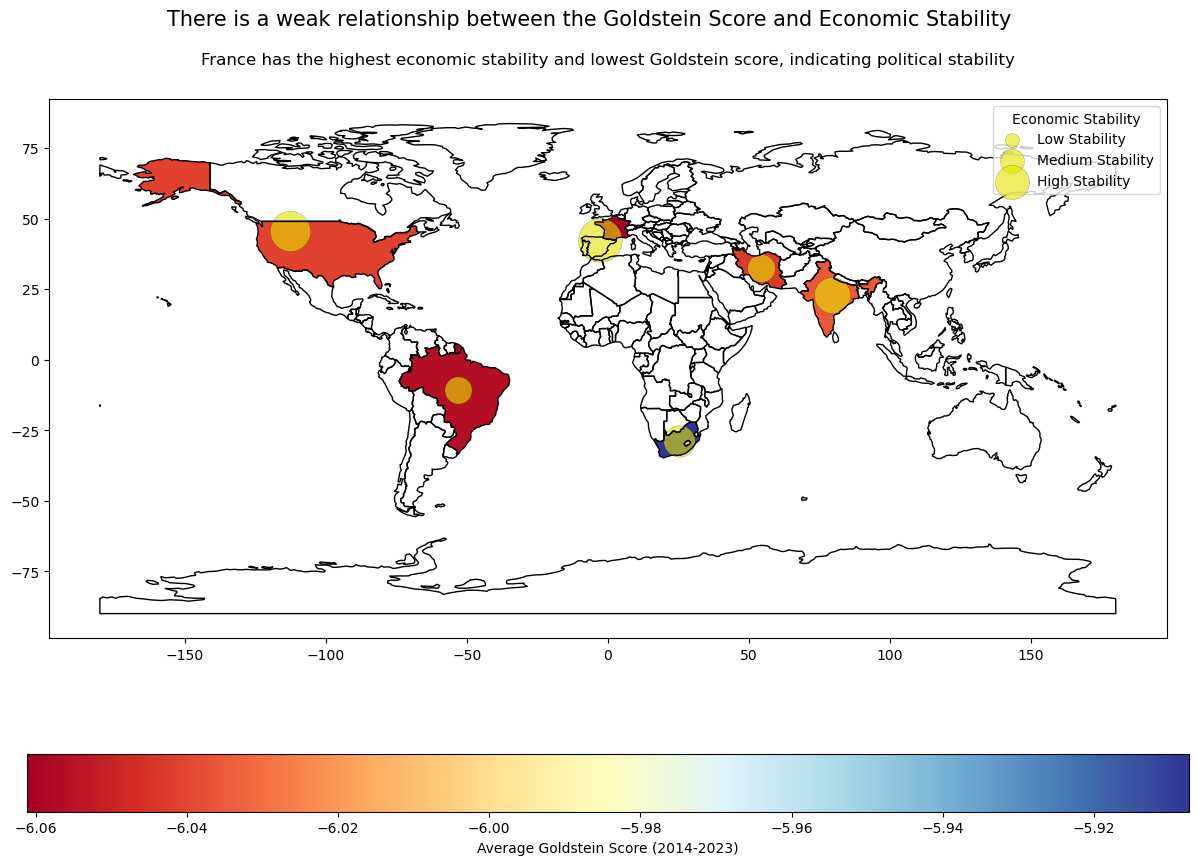

In [51]:
clean_world = goldstein_economic_world.dropna(subset=['avg_goldstein', 'total_economic_score']).copy()

size_factor = 50
clean_world['bubble_size'] = clean_world['total_economic_score'] * size_factor

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.boundary.plot(ax=ax, linewidth=1, color='black')

goldstein_economic_world.plot(ax=ax, column='avg_goldstein', cmap='RdYlBu', legend=True,
                       legend_kwds={'label': "Average Goldstein Score (2014-2023)", 'orientation': "horizontal"})

for idx, row in clean_world.iterrows():
    centroid = row['geometry'].centroid
    ax.scatter(centroid.x, centroid.y, s=row['bubble_size'], color='#e4e400', alpha=0.6, edgecolor='black', linewidth=0.2)

bubble_sizes = [100, 300, 600]
bubble_labels = ["Low Stability", "Medium Stability", "High Stability"]
legend_handles = [
    plt.scatter([], [], s=size, color='#e4e400', alpha=0.6, edgecolor='black', linewidth=0.2, label=label)
    for size, label in zip(bubble_sizes, bubble_labels)
]
ax.legend(handles=legend_handles, title="Economic Stability", loc='upper right', frameon=True)

plt.suptitle('There is a weak relationship between the Goldstein Score and Economic Stability', fontsize=15, y=0.97)
ax.set_title('France has the highest economic stability and lowest Goldstein score, indicating political stability', fontsize=12, y=1.05)

plt.show()
